In [1]:
from sklearn.preprocessing import StandardScaler
import pyupbit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# 데이터 로드
ticker = 'KRW-BTC'
interval = 'minute3'
to = '2024-10-31 09:00'
count = 13440
data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count)
# 이동평균 3과 5 계산
data['ma_3'] = data['close'].rolling(window=3).mean()  # 3-period 이동평균
data['ma_5'] = data['close'].rolling(window=5).mean()  # 5-period 이동평균
data['middle'] = (data['high'] + data['low']) / 2

#1달 데이터 3분간격

In [3]:
# NaN 값 제거 (초기 구간에서는 이동평균 계산 불가)
data = data.dropna()

In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"using PyTorch version: [torch.__version__], Device: {DEVICE}")

using PyTorch version: [torch.__version__], Device: cuda


In [5]:
data

,open,high,low,close,volume,value,ma_3,ma_5,middle
2024-10-03 12:39:00,82505000.0,82505000.0,82427000.0,82505000.0,2.966659,2.447083e+08,8.253700e+07,82558400.0,82466000.0
2024-10-03 12:42:00,82500000.0,82505000.0,82423000.0,82499000.0,1.690431,1.393662e+08,8.249833e+07,82546000.0,82464000.0
2024-10-03 12:45:00,82499000.0,82593000.0,82433000.0,82482000.0,3.699225,3.052489e+08,8.249533e+07,82518400.0,82513000.0
2024-10-03 12:48:00,82590000.0,82591000.0,82500000.0,82589000.0,0.558138,4.609081e+07,8.252333e+07,82513200.0,82545500.0
2024-10-03 12:51:00,82590000.0,82610000.0,82540000.0,82609000.0,2.760618,2.280237e+08,8.256000e+07,82536800.0,82575000.0
...,...,...,...,...,...,...,...,...,...
2024-10-31 17:45:00,100419000.0,100445000.0,100402000.0,100416000.0,1.881093,1.888933e+08,1.004213e+08,100428200.0,100423500.0
2024-10-31 17:48:00,100416000.0,100454000.0,100401000.0,100416000.0,2.048091,2.056766e+08,1.004170e+08,100426000.0,100427500.0
2024-10-31 17:51:00,100416000.0,100479000.0,100401000.0,100451000.0,2.179007,2.188510e+08,1.004277e+08,100426200.0,100440000.0
2024-10-31 17:54:00,100451000.0,100541000.0,100451000.0,100541000.0,2.542313,2.554695e+08,1.004693e+08,100448600.0,100496000.0


In [6]:
FEATURE_NUMS = 8 # 입력층 변수 개수
SEQ_LENGTH = 288 # 정답을 위한 필요한 시점 개수 TIME STEP
HIDDEN_SIZE = 4 # RNN 계열 계층을 구성하는 히든스테이트 개수
NUM_LAYERS = 1 # RNN 계열 계층이 몇겹으로 쌓였는지 나타냄
LEARNING_RATE = 1e-3  # 학습율
BATCH_SIZE = 20 #학습을 위한 배치사이즈 개수

In [7]:
SPLIT = int(0.7*len(data)) # 7:3

train_data = data[ :SPLIT ]
test_data = data[ SPLIT: ]

In [8]:
scaler_x = MinMaxScaler()

train_data.iloc[ : , :-1 ] = scaler_x.fit_transform(train_data.iloc[ : , :-1])
test_data.iloc[ : , :-1 ] = scaler_x.fit_transform(test_data.iloc[ : , :-1])

scaler_y = MinMaxScaler()

train_data.iloc[ : , -1 ] = scaler_y.fit_transform(train_data.iloc[ : , [-1]])
test_data.iloc[ : , -1 ] = scaler_y.fit_transform(test_data.iloc[ : , [-1]])


In [9]:
def MakeSeqNumpyData(data, seq_length):
    
    x_seq_list = []
    y_seq_list = []
    
    for i in range(len(data) - seq_length):
        x_seq_list.append(data[ i:i+seq_length, :-1])
        y_seq_list.append(data[ i+seq_length, [-1]])
    
    x_seq_numpy = np.array(x_seq_list)
    y_seq_numpy = np.array(y_seq_list)
    
    return x_seq_numpy, y_seq_numpy

In [10]:
x_train_data, y_train_data = MakeSeqNumpyData(np.array(train_data), SEQ_LENGTH)

x_test_data, y_test_data = MakeSeqNumpyData(np.array(test_data), SEQ_LENGTH)

print(x_train_data.shape, y_train_data.shape)
print(x_test_data.shape, y_test_data.shape)

(9117, 288, 8) (9117, 1)
(3743, 288, 8) (3743, 1)


In [11]:
x_train_tensor = torch.FloatTensor(x_train_data).to(DEVICE)
y_train_tensor = torch.FloatTensor(y_train_data).to(DEVICE)

x_test_tensor = torch.FloatTensor(x_test_data).to(DEVICE)
y_test_tensor = torch.FloatTensor(y_test_data).to(DEVICE)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size = BATCH_SIZE, shuffle=False)

In [12]:
class MyLSTMModel(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, data):
        h0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size).to(DEVICE)
        c0 = torch.zeros(self.num_layers, data.size(0), self.hidden_size).to(DEVICE)
        
        outputs,_ = self.lstm(data, (h0,c0))
        last_hs = outputs[:, -1, :]
        prediction = self.fc(last_hs)
        
        return prediction

In [13]:
model = MyLSTMModel(FEATURE_NUMS, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
def model_train(dataloader, model, loss_function, optimizer):
    
    model.train()
    
    train_loss_sum = 0
    
    total_train_batch = len(dataloader)
    
    for inputs, labels in dataloader:
        
        x_train = inputs.to(DEVICE)
        y_train = labels.to(DEVICE)
        
        outputs = model(x_train)
        loss = loss_function(outputs, y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_sum += loss.item()
    
    train_avg_loss = train_loss_sum / total_train_batch
    
    return train_avg_loss

In [15]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

MyLSTMModel(
  (lstm): LSTM(8, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [16]:
train_loss_list = []
EPOCHS = 200

for epoch in range(EPOCHS):
    
    avg_loss = model_train(train_loader, model, loss_function, optimizer)
    
    train_loss_list.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}]")

Epoch [10/200]
Epoch [20/200]
Epoch [30/200]
Epoch [40/200]
Epoch [50/200]
Epoch [60/200]
Epoch [70/200]
Epoch [80/200]
Epoch [90/200]
Epoch [100/200]
Epoch [110/200]
Epoch [120/200]
Epoch [130/200]
Epoch [140/200]
Epoch [150/200]
Epoch [160/200]
Epoch [170/200]
Epoch [180/200]
Epoch [190/200]
Epoch [200/200]


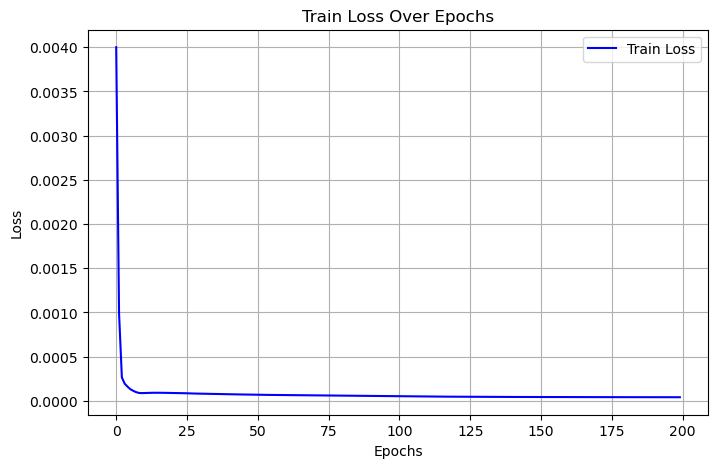

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_list, linestyle='-', color='b', label='Train Loss')
plt.title('Train Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
test_pred_tensor = model(x_test_tensor)

test_pred_numpy = test_pred_tensor.cpu().detach().numpy()

pred_inverse = scaler_y.inverse_transform(test_pred_numpy)

y_test_numpy = y_test_tensor.cpu().detach().numpy()

y_test_inverse = scaler_y.inverse_transform(y_test_numpy)

In [19]:
print(pred_inverse,5)
print(y_test_inverse,5)

[[9.23660320e+07]
 [9.22735040e+07]
 [9.23109280e+07]
 ...
 [1.00589944e+08]
 [1.00600600e+08]
 [1.00637624e+08]] 5
[[9.2320008e+07]
 [9.2286504e+07]
 [9.2299008e+07]
 ...
 [1.0043999e+08]
 [1.0049600e+08]
 [1.0055500e+08]] 5


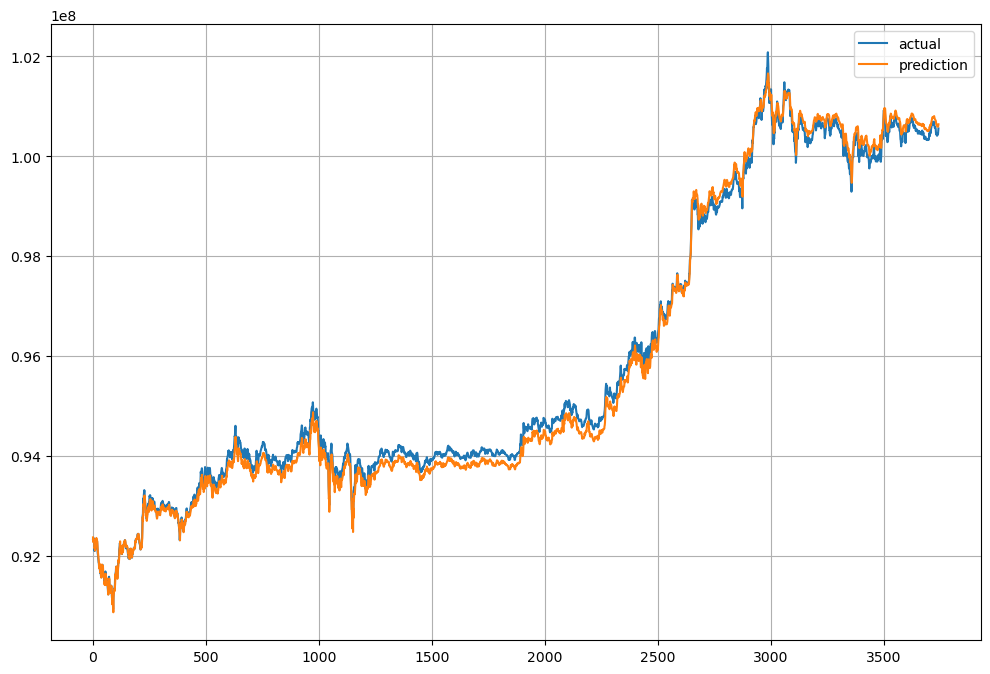

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_inverse, label='actual')
plt.plot(pred_inverse, label='prediction')
plt.grid()
plt.legend()

In [21]:
start_idx = 0
end_idx = 500
pred_subset = pred_inverse[start_idx:end_idx]
y_test_subset = y_test_inverse[start_idx:end_idx]

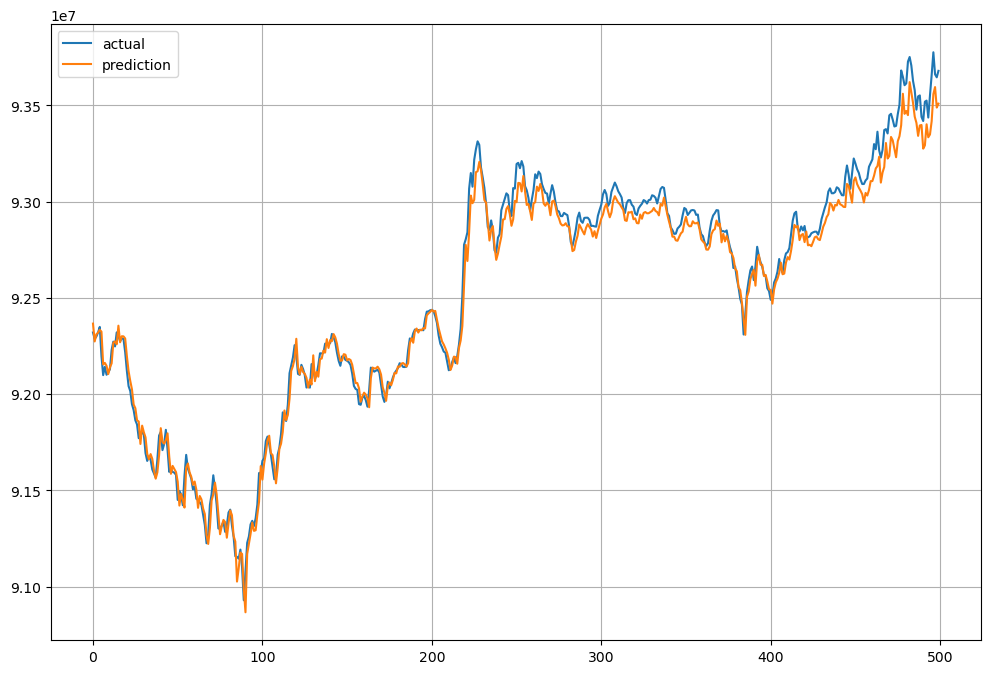

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_subset, label='actual')
plt.plot(pred_subset, label='prediction')
plt.grid()
plt.legend()

In [23]:
start_idx = 1500
end_idx = 2000
pred_subset = pred_inverse[start_idx:end_idx]
y_test_subset = y_test_inverse[start_idx:end_idx]

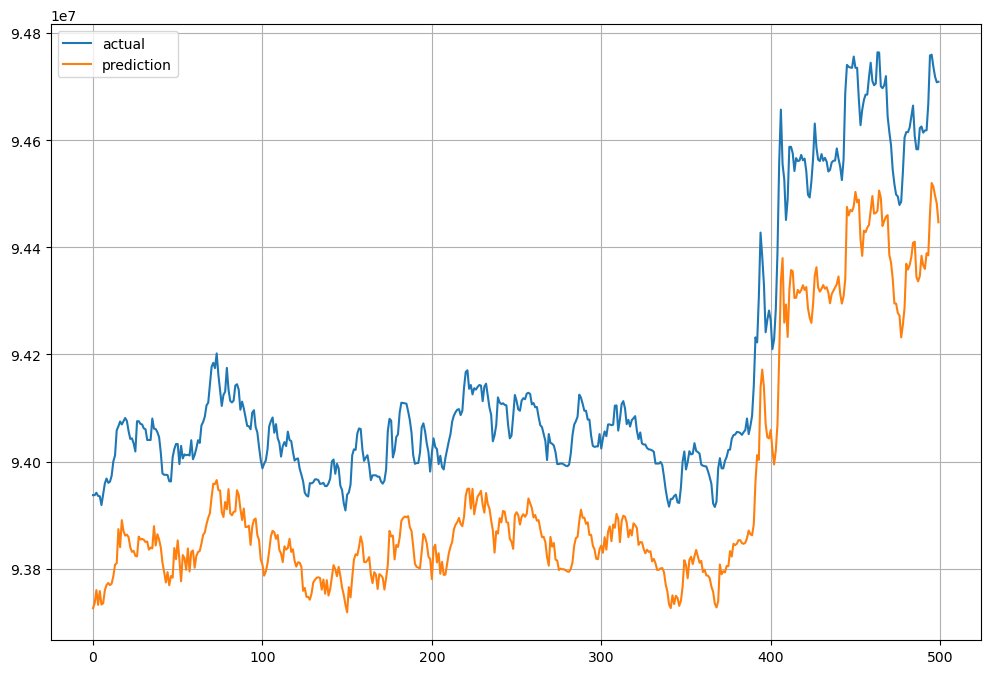

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_subset, label='actual')
plt.plot(pred_subset, label='prediction')
plt.grid()
plt.legend()

In [25]:
pred_subset

array([[93726392.],
       [93735784.],
       [93760320.],
       [93732840.],
       [93758480.],
       [93733392.],
       [93735696.],
       [93760160.],
       [93769816.],
       [93773536.],
       [93769600.],
       [93772312.],
       [93786280.],
       [93807632.],
       [93810760.],
       [93874088.],
       [93840520.],
       [93890848.],
       [93870528.],
       [93862040.],
       [93863784.],
       [93859080.],
       [93840320.],
       [93831648.],
       [93833536.],
       [93824160.],
       [93823352.],
       [93860192.],
       [93854736.],
       [93855888.],
       [93854168.],
       [93850048.],
       [93851104.],
       [93835760.],
       [93839584.],
       [93838256.],
       [93879608.],
       [93843592.],
       [93864536.],
       [93854784.],
       [93840216.],
       [93811656.],
       [93793856.],
       [93774608.],
       [93793792.],
       [93769368.],
       [93786568.],
       [93783384.],
       [93838776.],
       [93817904.],


In [26]:
def calculate_metrics(pred, true):
    """
    MAE, MSE, RMSE, MAPE, MSPE 계산
    :param pred: 예측값 (1D array)
    :param true: 실제값 (1D array)
    :return: 각 지표의 값
    """
    mae = np.mean(np.abs(pred - true))  # Mean Absolute Error
    mse = np.mean((pred - true) ** 2)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    mape = np.mean(np.abs((true - pred) / true)) * 100  # Mean Absolute Percentage Error
    mspe = np.mean(((true - pred) / true) ** 2) * 100  # Mean Squared Percentage Error

    return mae, mse, rmse, mape, mspe


In [27]:
# 평가 지표 계산
mae, mse, rmse, mape, mspe = calculate_metrics(pred_subset, y_test_subset)

# 결과 출력
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"MSPE: {mspe:.4f}%")


MAE: 211126.4844
MSE: 45408550912.0000
RMSE: 213092.8281
MAPE: 0.22%
MSPE: 0.0005%
